In [ ]:
!pip install optuna nltk rouge-score datasets matplotlib bert-score


Defaulting to user installation because normal site-packages is not writeable


In [ ]:
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from rouge_score import rouge_scorer
from datasets import load_dataset
from nltk.translate.meteor_score import meteor_score
from bert_score import score
import optuna
import numpy as np
import matplotlib.pyplot as plt
import re
nltk.download('punkt')
nltk.download('stopwords')


/apps/cent7/jupyterhub/lib/python3.9/site-packages/nltk/metrics/association.py:26: UserWarning: A NumPy version >=1.22.4 and <2.3.0 is required for this version of SciPy (detected version 1.21.2)
  from scipy.stats import fisher_exact
[nltk_data] Downloading package punkt to /home/desai226/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/desai226/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
stop_words = set(stopwords.words('english'))
# Text Preprocessing
def preprocess_text(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove special characters
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    words = text.split()
    words = [word.lower() for word in words if word.lower() not in stop_words]
    return ' '.join(words)


In [ ]:
def textrank_summarize_with_params(text, top_n=3, similarity_threshold=0.1):
    sentences = sent_tokenize(text)
    cleaned_sentences = [preprocess_text(sentence) for sentence in sentences]

    # Creating sentence similarity matrix
    sentence_vectors = [set(sent.split()) for sent in cleaned_sentences]
    similarity_matrix = np.zeros((len(sentences), len(sentences)))

    for i in range(len(sentence_vectors)):
        for j in range(len(sentence_vectors)):
            if i != j:
                similarity_matrix[i][j] = len(sentence_vectors[i].intersection(sentence_vectors[j]))

    # Applying similarity threshold
    similarity_matrix = np.where(similarity_matrix > similarity_threshold, similarity_matrix, 0)

    # Ranking sentences using the sum of similarity scores
    scores = np.sum(similarity_matrix, axis=1)
    ranked_sentences = [sentences[i] for i in np.argsort(scores)[::-1]]

    return ' '.join(ranked_sentences[:top_n])


In [ ]:
# Function to load and clean data
def load_and_clean_data():
    train_data = load_dataset("ragha92/FNS_Summarization", split="train")
    validation_data = load_dataset("ragha92/FNS_Summarization", split="validation")
    test_data = load_dataset("ragha92/FNS_Summarization", split="test")

    columns = ['Annual Reports', 'Gold Summaries']
    train_data = train_data.filter(lambda x: all(x[col] is not None for col in columns))
    validation_data = validation_data.filter(lambda x: all(x[col] is not None for col in columns))
    test_data = test_data.filter(lambda x: all(x[col] is not None for col in columns))

    return train_data, validation_data, test_data

train_data, validation_data, test_data = load_and_clean_data()
print("Datasets loaded and cleaned.")


Datasets loaded and cleaned.


In [ ]:
# Function to find best hyperparameters using optuna
def objective(trial):
    top_n = trial.suggest_int("top_n", 1, 5)
    similarity_threshold = trial.suggest_uniform("similarity_threshold", 0.0, 1.0)

    sample_validation_data = validation_data.shuffle(seed=np.random.randint(0, 10000)).select(range(50))
    scorer = rouge_scorer.RougeScorer(['rouge1'], use_stemmer=True)
    rouge1_scores = []

    for item in sample_validation_data:
        input_text = item['Annual Reports']
        gold_summary = item['Gold Summaries']

        generated_summary = textrank_summarize_with_params(input_text, top_n=top_n, similarity_threshold=similarity_threshold)
        rouge_scores = scorer.score(gold_summary, generated_summary)
        rouge1_scores.append(rouge_scores['rouge1'].fmeasure)

    return -np.mean(rouge1_scores)  # Negative for Optuna minimization


In [ ]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=10)
best_params = study.best_params
print("Best Hyperparameters:", best_params)


[I 2024-12-05 16:21:13,509] A new study created in memory with name: no-name-3766c178-727c-4322-849f-5494689716b7
/tmp/ipykernel_122055/1952252970.py:3: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  similarity_threshold = trial.suggest_uniform("similarity_threshold", 0.0, 1.0)
[I 2024-12-05 16:21:34,808] Trial 0 finished with value: -0.07176705721146762 and parameters: {'top_n': 2, 'similarity_threshold': 0.523808616592644}. Best is trial 0 with value: -0.07176705721146762.
[I 2024-12-05 16:21:57,375] Trial 1 finished with value: -0.07477166975531878 and parameters: {'top_n': 5, 'similarity_threshold': 0.941279954462481}. Best is trial 1 with value: -0.07477166975531878.
[I 2024-12-05 16:22:23,944] Trial 2 finished with value: -0.0603484217550167 and parameters: {'top_n': 5, 'similarity_threshold': 0.2155785701555808}. Best is trial 1 with value

Best Hyperparameters: {'top_n': 2, 'similarity_threshold': 0.4389363046886381}


In [ ]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk.tokenize import word_tokenize

def evaluate_with_params(dataset, params):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    scores = {'rouge1': [], 'rouge2': [], 'rougeL': [], 'meteor': [], 'bleu': [], 'bertscore': []}

    # BLEU requires a smoothing function
    smooth = SmoothingFunction().method4

    references, candidates = [], []

    for item in dataset:
        input_text = item['Annual Reports']
        gold_summary = item['Gold Summaries']

        # Generating summary using TextRank
        generated_summary = textrank_summarize_with_params(
            input_text,
            top_n=params['top_n'],
            similarity_threshold=params['similarity_threshold']
        )

        # ROUGE Scores
        rouge_scores = scorer.score(gold_summary, generated_summary)
        scores['rouge1'].append(rouge_scores['rouge1'].fmeasure)
        scores['rouge2'].append(rouge_scores['rouge2'].fmeasure)
        scores['rougeL'].append(rouge_scores['rougeL'].fmeasure)

        # METEOR
        gold_tokens = word_tokenize(gold_summary)
        generated_tokens = word_tokenize(generated_summary)
        scores['meteor'].append(meteor_score([gold_tokens], generated_tokens))


        # Preparing for BERTScore
        references.append(gold_summary)
        candidates.append(generated_summary)


        # BLEU Score
        scores['bleu'].append(
            sentence_bleu([gold_tokens], generated_tokens, smoothing_function=smooth)
        )


    # BERTScore
    P, R, F1 = score(candidates, references, lang="en", verbose=True)
    scores['bertscore'] = F1.numpy().tolist()

    # Average the metrics
    return {metric: np.mean(values) for metric, values in scores.items()}


In [ ]:
val_scores = evaluate_with_params(validation_data, best_params)
test_scores = evaluate_with_params(test_data, best_params)

print("Validation Scores:", val_scores)
print("Test Scores:", test_scores)


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/8 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/5 [00:00<?, ?it/s]

done in 71.42 seconds, 3.60 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/8 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/5 [00:00<?, ?it/s]

done in 66.92 seconds, 3.87 sentences/sec
Validation Scores: {'rouge1': 0.07157823540072812, 'rouge2': 0.06806520620928924, 'rougeL': 0.0690344998907054, 'meteor': 0.1310383754764382, 'bleu': 0.0375462446969649, 'bertscore': 0.8104796901287272}
Test Scores: {'rouge1': 0.07619422613256724, 'rouge2': 0.07037418022419854, 'rougeL': 0.07279337923861294, 'meteor': 0.12998487264043487, 'bleu': 0.039894092207479, 'bertscore': 0.8029588615111862}


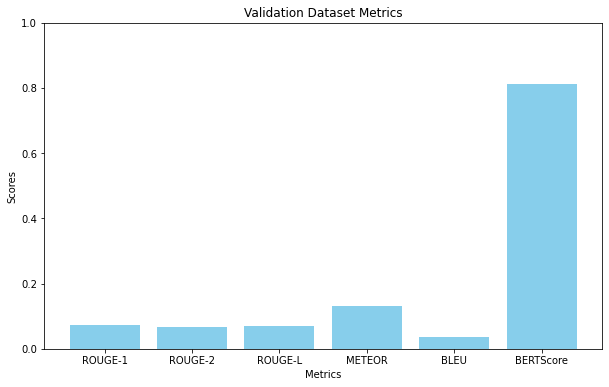

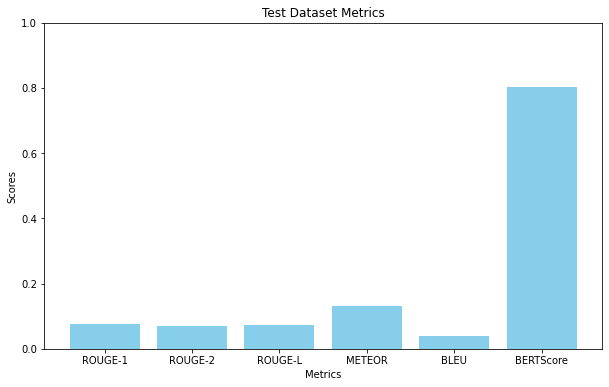

In [ ]:
# Function for visualizing metrics
def visualize_metrics(metrics, metric_names, dataset_type="Validation"):
    plt.figure(figsize=(10, 6))
    plt.bar(metric_names, metrics, color='skyblue')
    plt.xlabel('Metrics')
    plt.ylabel('Scores')
    plt.title(f'{dataset_type} Dataset Metrics')
    plt.ylim(0, 1)
    plt.show()

# Visualizing metrics
metric_names = ['ROUGE-1', 'ROUGE-2', 'ROUGE-L', 'METEOR', 'BLEU', 'BERTScore']
visualize_metrics(list(val_scores.values()), metric_names, dataset_type="Validation")
visualize_metrics(list(test_scores.values()), metric_names, dataset_type="Test")


In [ ]:
print("Validation Scores:", val_scores)

Validation Scores: {'rouge1': 0.07157823540072812, 'rouge2': 0.06806520620928924, 'rougeL': 0.0690344998907054, 'meteor': 0.1310383754764382, 'bleu': 0.0375462446969649, 'bertscore': 0.8104796901287272}


In [ ]:
# Function to display summaries
def display_sample_summaries_textrank(dataset, params, num_samples=3):
    """
    Display gold summaries and generated summaries for the first few records
    in the dataset using the TextRank summarization approach.

    Args:
        dataset (list): Dataset containing 'Annual Reports' and 'Gold Summaries'.
        params (dict): Hyperparameters for TextRank summarization (top_n and similarity_threshold).
        num_samples (int): Number of samples to display.
    """
    sample_summaries = []

    for idx, item in enumerate(dataset):
        if idx >= num_samples:
            break

        # Extracting input text and gold summary
        input_text = item['Annual Reports']
        gold_summary = item['Gold Summaries']

        if not input_text or not gold_summary:
            continue

        # Generating TextRank summary
        generated_summary = textrank_summarize_with_params(
            input_text,
            top_n=params['top_n'],
            similarity_threshold=params['similarity_threshold']
        )

        # Storing summaries for display
        sample_summaries.append({
            'input_text': input_text,
            'gold_summary': gold_summary,
            'generated_summary': generated_summary
        })

    # Displaying summaries for each sample
    for idx, summary in enumerate(sample_summaries):
        print(f"Sample {idx + 1}:")
        print(f"Input Text (first 500 characters):\n{summary['input_text'][:500]}...")
        print(f"\nGold Summary (first 1500 characters):\n{summary['gold_summary'][:1500]}")
        print(f"\nGenerated Summary (first 1500 characters):\n{summary['generated_summary'][:1500]}")
        print("\n" + "=" * 50 + "\n")

# Sisplaying summaries for the first 3 records from the test dataset
display_sample_summaries_textrank(test_data, best_params, num_samples=3)


Sample 1:
Input Text (first 500 characters):
 renew holdings plc annual report and accounts 2011
delivering 
engineering services 
to uk infrastructure
renew holdings plc annual report and accounts 2011 highlights
  engineering services revenue up 39 to £1767m 
2010 £1274m
	 	 engineering 	 services 	 adjusted 	 operating 	 profit 	
up 78 to £74m 2010 £42m 
  group order book of £285m 2010 £304m including 
engineering services order book up 118 to £179m 
2010 £82m 
  acquisition of engineering services business amco 
now fully integrated
 ...

Gold Summary (first 1500 characters):
 06
renew holdings plc
annual report and accounts 2011 chief executive’s review
renew is now positioned as an engineering 
services group supporting uk infrastructure 
2011 	 has 	 been 	 a 	 significant 	 year 	 for 	 the 	 group 	
which with further organic growth and the 
acquisition of amco has achieved its target 
of shifting the balance of operations into 
engineering services 
engineering services
engi